# ДЗ (Обучение без учителя)

Задание на кластеризацию, понижение размерности и классификацию.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.colors import ListedColormap

%matplotlib inline


plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

import gc

sns.set()
%matplotlib inline

import sys
# np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
# np.set_printoptions(precision=3)

DISPLAY_MAX_ROWS = 20 #20
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)
pd.set_option('display.max_column', 100) # None)
plt.style.use('seaborn-whitegrid')


# plt.rcParams["figure.figsize"] = (20, 15)

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 17

C:\Users\sharp\AppData\Local\Temp\ipykernel_14636\2058982965.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-darkgrid'])
C:\Users\sharp\AppData\Local\Temp\ipykernel_14636\2058982965.py:35: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
X_train = np.loadtxt("../../data/samsung_train.txt")
y_train = np.loadtxt("../../data/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../../data/samsung_test.txt")
y_test = np.loadtxt("../../data/samsung_test_labels.txt").astype(int)

In [4]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [5]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
X.shape, y.shape

((10299, 561), (10299,))

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбa
- 2 - подъем вверх по лестнице
- 3 - спуск по лестнице
- 4 - сидит
- 5 - стоит
- 6 - лежит



Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [79]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [80]:
pca = PCA(0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

We need 65 components to explain 90% of variance


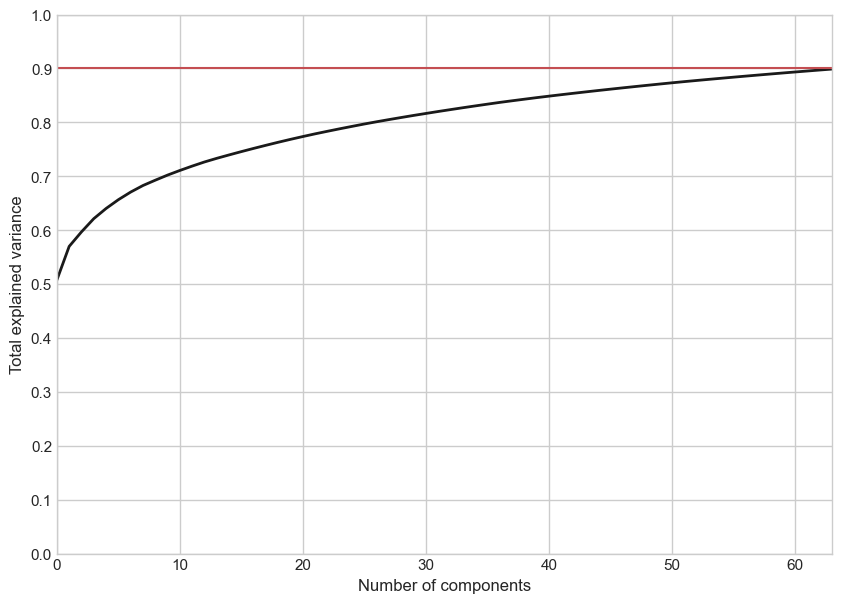

In [81]:
print('We need %d components to explain 90%% of variance' 
      % pca.n_components_)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(pca.n_components_, c='b')
plt.axhline(0.9, c='r')
plt.show()

# pca.explained_variance_ratio_

**Варианты:**
- 56 
- ``65``
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- ``51``
- 56
- 61

In [82]:
round(pca.explained_variance_ratio_[0]*100)

51

Визуализируйте данные в проекции на первые две главные компоненты.

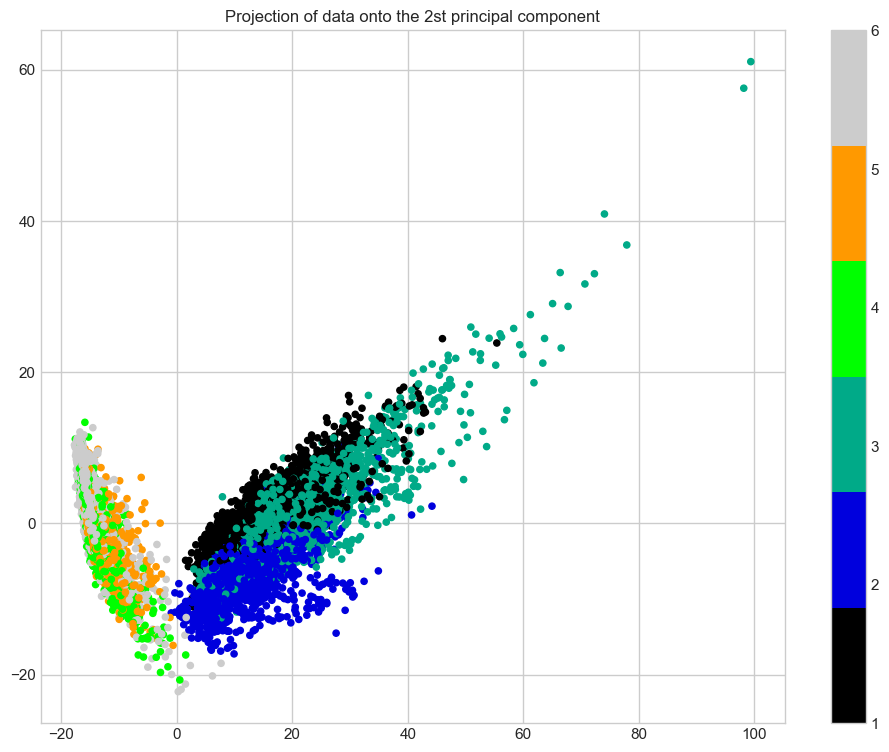

In [83]:
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.title('Projection of data onto the 2st principal component')
plt.colorbar()
plt.show()

- 1 - ходьбa
- 2 - подъем вверх по лестнице
- 3 - спуск по лестнице
- 4 - сидит
- 5 - стоит
- 6 - лежит

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- ``2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)``
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [84]:
kmeans = KMeans(n_clusters = n_classes, n_init=100, random_state = RANDOM_STATE)
y_kmeans = kmeans.fit_predict(X_pca)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

In [85]:
# cluster_labels = ['ходьба', 'подъем вверх по лестнице', 
#              'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']

cluster_labels = y_kmeans


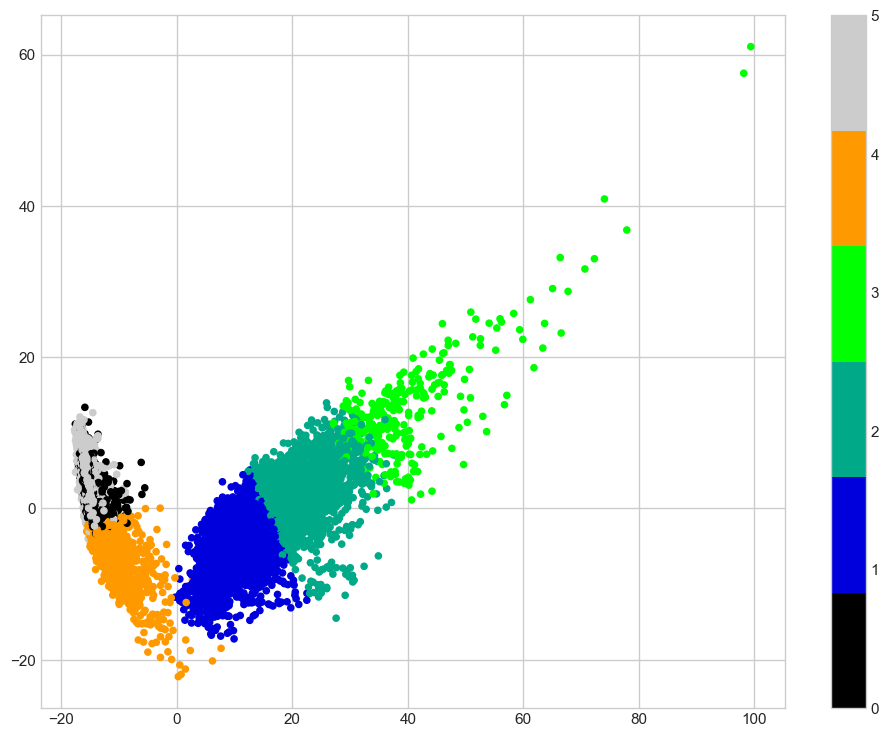

In [86]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  cmap=plt.cm.get_cmap('nipy_spectral', 6));
plt.colorbar()
# plt.scatter(X_pca[y_kmeans == 0, 0], X_pca[y_kmeans == 0, 1], s = 20, c = 'red', label = 'Cluster 1')
# plt.scatter(X_pca[y_kmeans == 1, 0], X_pca[y_kmeans == 1, 1], s = 20, c = 'blue', label = 'Cluster 2')
# plt.scatter(X_pca[y_kmeans == 2, 0], X_pca[y_kmeans == 2, 1], s = 20, c = 'green', label = 'Cluster 3')
# plt.scatter(X_pca[y_kmeans == 3, 0], X_pca[y_kmeans == 3, 1], s = 20, c = 'cyan', label = 'Cluster 4')
# plt.scatter(X_pca[y_kmeans == 4, 0], X_pca[y_kmeans == 4, 1], s = 20, c = 'magenta', label = 'Cluster 5')
# plt.scatter(X_pca[y_kmeans == 5, 0], X_pca[y_kmeans == 5, 1], s = 20, c = 'black', label = 'Cluster 5')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 20, c = 'yellow', label = 'Centroids')

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [87]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- ``перечисленные варианты не подходят (подходит лежание)`` 

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

  0%|          | 0/6 [00:00<?, ?it/s]

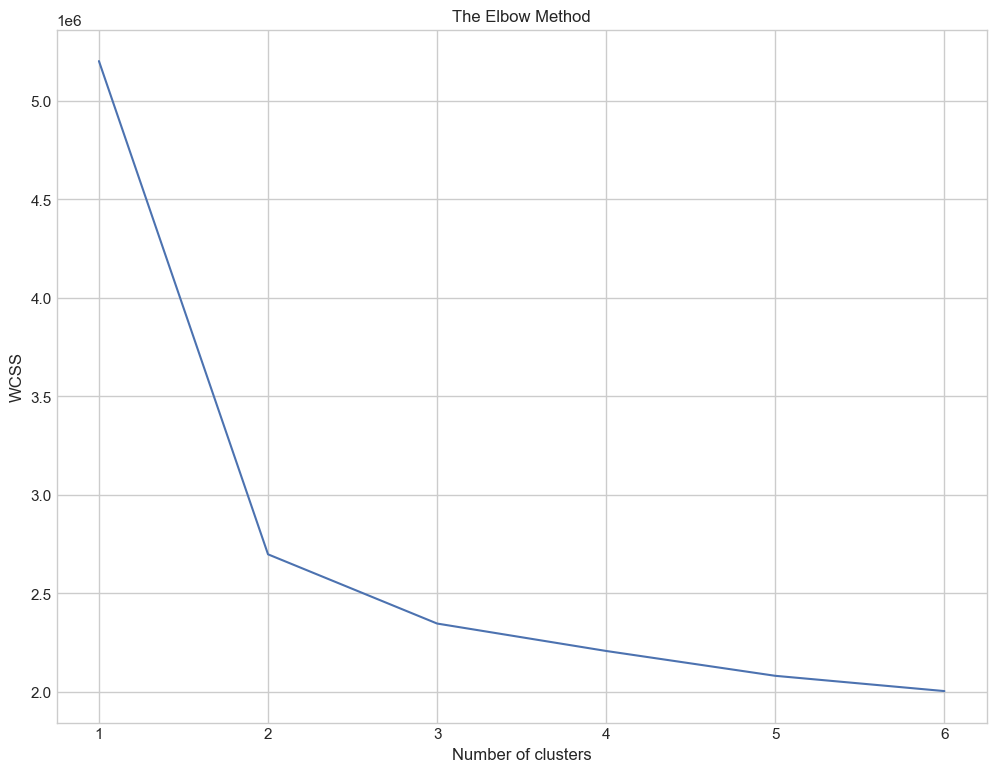

In [88]:
# Ваш код здесь
wcss = [] 
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters = k, n_init=100, random_state = RANDOM_STATE)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, n_classes + 1), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- ``3 (так как далее данные сходятся)``
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [65]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [71]:
print("Adjusted Rand-Index for Agglomerative Clustering: %.3f"
      % metrics.adjusted_rand_score(y, ag.labels_))

print("Adjusted Rand-Index for KMeans Clustering: %.3f"
      % metrics.adjusted_rand_score(y, kmeans.labels_))

Adjusted Rand-Index for Agglomerative Clustering: 0.494
Adjusted Rand-Index for KMeans Clustering: 0.420


**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- ``Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering``
- ``Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры``
- ``В случае случайного разбиения на кластеры ARI будет близок к нулю``

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [72]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [74]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [75]:
best_svc = GridSearchCV(svc,
              param_grid=svc_params,
              cv=3).fit(X_train, y_train)

best_svc.best_score_

0.9464116548292103

In [76]:
best_svc.best_params_

{'C': 1}

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- ``1``
- 10

In [77]:
y_predicted = best_svc.predict(X_test_scaled)

In [78]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,439,33,4,12,8,0,496
подъем вверх по лестнице,1,466,1,3,0,0,471
спуск по лестнице,1,16,375,10,18,0,420
сидение,2,6,0,346,136,1,491
стояние,2,2,0,9,519,0,532
лежание,1,2,1,30,18,485,537
все,446,525,381,410,699,486,2947


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- ``по точности – сидение, по полноте – стояние``

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- ``4%``
- 10%
- 20%


In [89]:
pca = PCA(0.9, random_state=RANDOM_STATE)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [90]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

best_svc = GridSearchCV(svc,
              param_grid=svc_params,
              cv=3)
best_svc.fit(X_train_scaled_pca, y_train)

GridSearchCV(cv=3, estimator=LinearSVC(random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [91]:
best_svc.best_score_, best_svc.best_params_

(0.8998943094169531, {'C': 1})

**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- ``PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность``
- ``PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком``